# Traffic light detection

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm
import os
import urllib
import tarfile

%matplotlib inline
plt.style.use('ggplot')

## Prepare models
Download the pretrained models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

In [3]:

MOBILNET = 'ssd_mobilenet_v1_coco_11_06_2017'
RFCN = 'rfcn_resnet101_coco_11_06_2017'
FASTER_INCEPTION = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017'
INCEPTION = 'ssd_inception_v2_coco_11_06_2017'
FASTER_RCNN='faster_rcnn_resnet101_coco_11_06_2017'
MODEL_NAMES = [MOBILNET,RFCN,FASTER_INCEPTION,FASTER_RCNN,INCEPTION]
MODEL_FILE_ENDING = '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
MODELS_DIR='models'

if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
model_directories = os.listdir(MODELS_DIR)
for model_name in MODEL_NAMES:
    if model_name not in model_directories:
        opener = urllib.request.URLopener()
        model_file = model_name + MODEL_FILE_ENDING
        deployed_model = os.path.join(MODELS_DIR,model_file)
        opener.retrieve(DOWNLOAD_BASE +  model_file ,deployed_model)
        tar_file = tarfile.open(deployed_model)
        for file in tar_file.getmembers():
            file_name = os.path.basename(file.name)
            if 'frozen_inference_graph.pb' in file_name:
                tar_file.extract(file, MODELS_DIR)

## Helper functions

Below are utility functions. The main purpose of these is to filter the network results and draw the bounding boxes back onto the original image.

In [ ]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes, categories):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if classes[i] in categories and scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        

## Detection functions

In [13]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
        # The input placeholder for the image.
        # `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
        image_tensor = graph.get_tensor_by_name('image_tensor:0')

        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = graph.get_tensor_by_name('detection_boxes:0')

        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = graph.get_tensor_by_name('detection_scores:0')

        # The classification of the object (integer id).
        detection_classes = graph.get_tensor_by_name('detection_classes:0')
    return graph, image_tensor, detection_boxes,detection_scores,detection_classes

In [38]:
def detect(detection_graph,
           image_tensor, 
           detection_boxes,
           detection_scores,
           detection_classes,
           image_np,
           categories,
           runs=1):
  
    with tf.Session(graph=detection_graph) as sess:                
        # Actual detection.
        
        times = np.zeros(runs)
        for i in range(runs):
            t0 = time.time()
            (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                                feed_dict={image_tensor: image_np})
            t1 = time.time()
            times[i] = (t1 - t0) * 1000

        # Remove unnecessary dimensions
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes)

        confidence_cutoff = 0.8
        traffic_lights_class_id=10
        # Filter boxes with a confidence score less than `confidence_cutoff`
        boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes,[traffic_lights_class_id])
        return boxes, scores, classes, times

def ilustrate_detection(boxes, classes,title):
        # The current box coordinates are normalized to a range between 0 and 1.
        # This converts the coordinates actual location on the image.
        width, height = image.size
        box_coords = to_image_coords(boxes, height, width)

        # Each class with be represented by a differently colored box
        draw_boxes(image, box_coords, classes)
        fig = plt.figure(figsize=(12, 8))
        fig.suptitle(title, fontsize=10)
        plt.imshow(image) 

## Detect objects in test images

In [39]:
import glob
frozen_model_paths=[graph for graph in glob.iglob(MODELS_DIR+'/**/*.pb', recursive=True)]
test_image_paths= [ graph for graph in glob.iglob('test_images/*.jpg', recursive=True)]
traffic_sign_class_id = 10
test_image=test_image_paths[1]

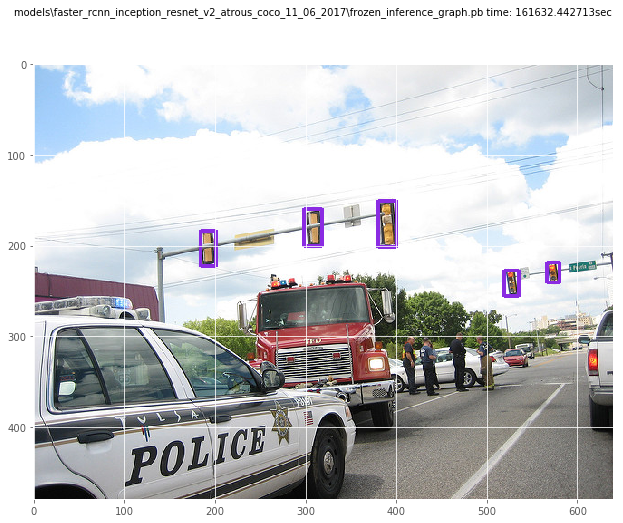

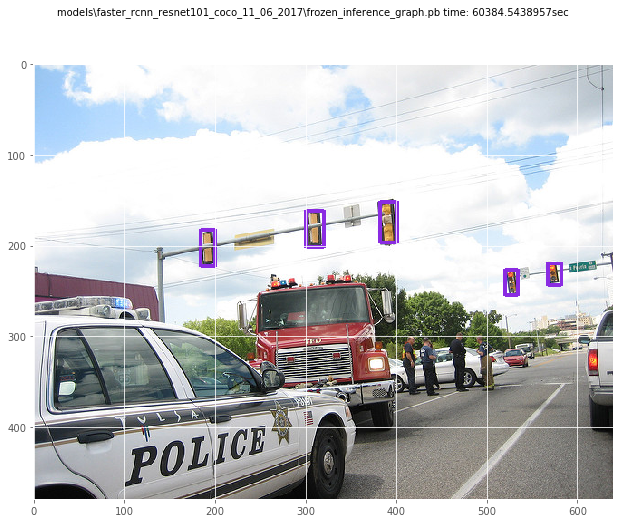

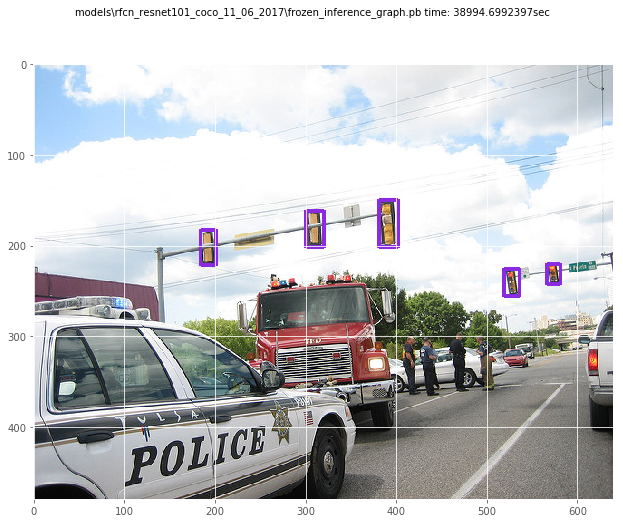

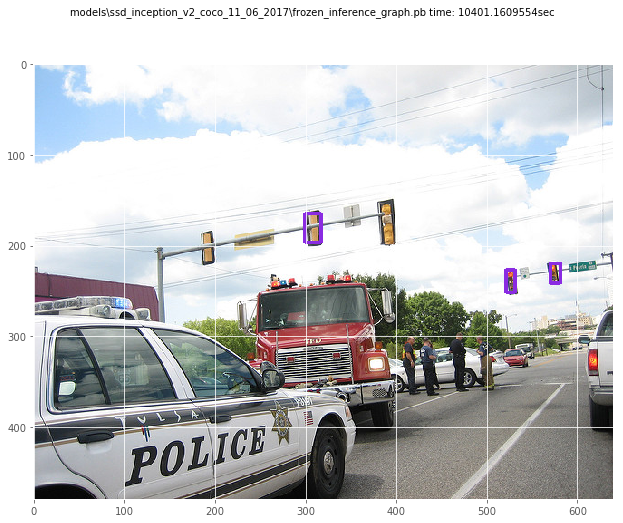

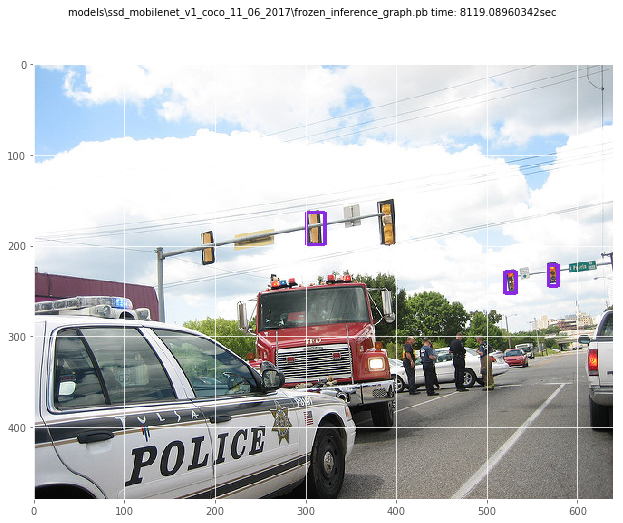

In [40]:
for model in frozen_model_paths:
    detection_graph,image_tensor,detection_boxes,detection_scores,detection_classes = load_graph(model)
    image = Image.open(test_image)
    image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
    boxes,scores,classes,times = detect(detection_graph,
                                  image_tensor,
                                  detection_boxes,
                                  detection_scores,
                                  detection_classes,
                                  image_np,
                                  traffic_sign_class_id)
    ilustrate_detection(boxes,classes,model+' time: '+str(times[0])+'sec')

## Timing Mobilenet

In [42]:
mobile_net_path=[path for path in frozen_model_paths
                if 'mobilenet' in path][0]

In [44]:
detection_graph,image_tensor,detection_boxes,detection_scores,detection_classes = load_graph(mobile_net_path)
image = Image.open(test_image)
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
_,_,_,times = detect(detection_graph,
                              image_tensor,
                              detection_boxes,
                              detection_scores,
                              detection_classes,
                              image_np,
                              traffic_sign_class_id,
                                    5)

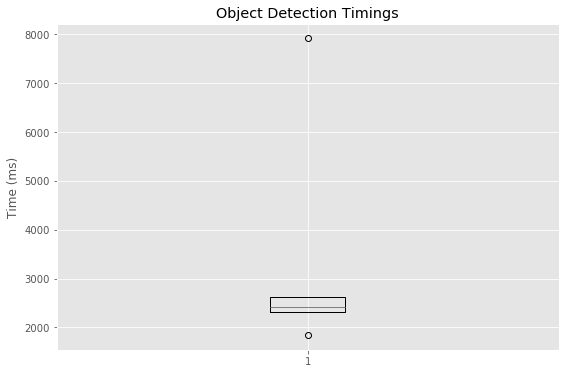

In [45]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)